<a href="https://colab.research.google.com/github/kaylaque/glauco-scan/blob/main/Glaucoma_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading from [Kaggle](https://www.kaggle.com/sshikamaru/glaucoma-detection/version/2/metadata)

In [ ]:
# upload kaggle.json from your account kaggle API here
from google.colab import files
files.upload() #this will prompt you to update the json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"azim0275","key":"f70cbd4d4469be41ddb9ec7096af8007"}'}

In [ ]:
cd

/root


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ #change /content/.... with your own directory of kaggle.json
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
cd

/root


In [ ]:
#upload file from kaggle competition into gdrive
!kaggle datasets download --force -d sshikamaru/glaucoma-detection/ -p '/content/drive/MyDrive/Data Science'

100% 187M/188M [00:01<00:00, 125MB/s]
100% 188M/188M [00:01<00:00, 127MB/s]


In [ ]:
import zipfile
%cd '/content/drive/MyDrive/Data Science/'
fname = '/content/drive/MyDrive/Data Science/glaucoma-detection.zip'
zip = zipfile.ZipFile(fname, "r")
zip.extractall()
zip.close()

/content/drive/MyDrive/Data Science


# SVM on CDR


## Import dataset and library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.svm import SVC 

from sklearn.model_selection import GridSearchCV

In [ ]:
%cd /content/drive/MyDrive/HackathonIGI

/content/drive/MyDrive/HackathonIGI


In [ ]:
glcm_df = pd.read_csv("/content/drive/MyDrive/HackathonIGI/glaucoma-kaggle/glaucoma.csv")

In [ ]:
glcm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Eye       650 non-null    object 
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB


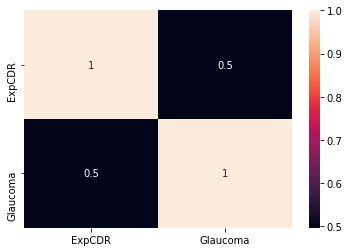

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = glcm_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# Remove column unnamed
glcm_df = glcm_df.drop(['Filename', 'Eye', 'Set'], axis = 1)

In [ ]:
glcm_df.tail(10)

,ExpCDR,Glaucoma
640,0.5677,1
641,0.5837,0
642,0.6207,0
643,0.6675,1
644,0.7111,1
645,0.6560,1
646,0.7365,1
647,0.5101,1
648,0.5227,0
649,0.6195,1


Int64Index([0, 1], dtype='int64')


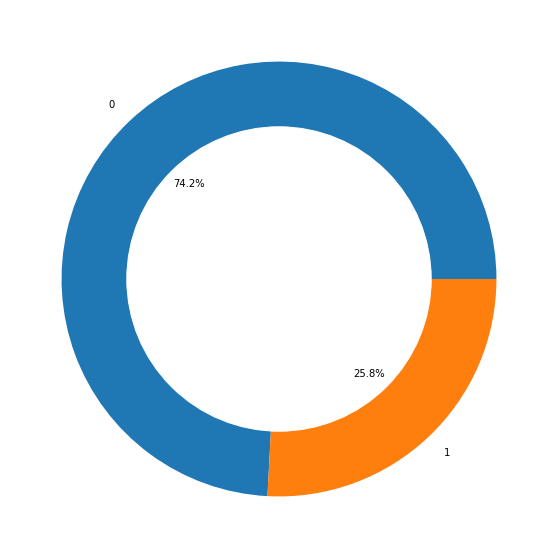

In [ ]:
label_distr = glcm_df['Glaucoma'].value_counts()
print(label_distr.index)
label_name = [0, 1]
plt.figure(figsize=(20,10))

my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(label_distr, 
        labels=label_name,  
        autopct='%1.1f%%')

p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Prepare Dataset

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Normalization decimal scaling

In [ ]:
def decimal_scaling(data):
    data = np.array(data, dtype=np.float32)
    max_row = data.max(axis=0)
    c = np.array([len(str(int(number))) for number in np.abs(max_row)])
    return data/(10**c)

In [ ]:
X = decimal_scaling(
            glcm_df[['ExpCDR']].values)

### Label encoding & categoricalize output vector

In [ ]:
le = LabelEncoder()
le.fit(glcm_df["Glaucoma"].values)
le.classes_

array([0, 1])

In [ ]:
y = le.transform(glcm_df['Glaucoma'].values)
# Y = to_categorical(Y)
print(y)
print(len(y))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 

## SVM

In [ ]:
# import support vector classifier 
# "Support Vector Classifier" 
scores= []
n_splits=10
clf = SVC(kernel='rbf', C = 1000, gamma = 100) 
cv = KFold(n_splits, random_state=27, shuffle=False)

for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    
    # fitting x samples and y classes 
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

Train Index:  [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
clf.score(X_test, y_test)

0.4

In [ ]:
import joblib
# save the model to disk
filename = 'svm_kf10_83.6% acc.sav'
joblib.dump(clf, filename)

['svm_kf10_83.6% acc.sav']

In [ ]:
scores_5

In [ ]:
scores

[0.8923076923076924,
 0.8769230769230769,
 0.9076923076923077,
 0.8615384615384616,
 0.7538461538461538,
 0.7538461538461538,
 0.8615384615384616,
 0.7692307692307693,
 0.8153846153846154,
 0.4]

In [ ]:
# x = list(range(1, n_splits+1, 1))
x1 = list(range(1, 11, 1))
y1 = scores
plt.plot(x1, y1, label = "kf = 10")
plt.title("K-fold's Scores")
plt.xlabel('K-Fold iteration')
plt.ylabel('Score')
plt.legend()
plt.show()

### Gridsearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV
# import support vector classifier 
# "Support Vector Classifier" 
res_kf = []
n_splits=10
cv = KFold(n_splits, random_state=27, shuffle=False)
# defining parameter range
param_grid = {'C': [1000, 2500, 5000, 10000, 10500],
              'gamma': [100, 50, 25, 10, 1],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    
    # fitting x samples and y classes 
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    # fitting the model for grid search
    grid.fit(X_train, y_train)
    res_kf.append(grid.score(X_test, y_test))

Train Index:  [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.812, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.718, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.821, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.726, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.821, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.718, total=   0.0s
[CV] C=1000, gamma=50, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.778, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.709, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.752, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.709, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.778, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.778, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Train Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.821, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.838, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.718, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.821, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.838, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ... C=1000, gamma=100, kernel=sigmoid, score=0.769, total=   0.0s
[CV] C=1000, gamma=100, kernel=sigmoid ...............................
[CV] ... C=1000, gamma=100, kernel=sigmoid, score=0.821, total=   0.0s
[CV] C=1000, gamma=100, kernel=sigmoid ...............................
[CV] ... C=1000, gamma=100, kernel=sigmoid, score=0.829, total=   0.0s
[CV] C=1000, gamma=100, kernel=sigmoid ...............................
[CV] ... C=1000, gamma=100, kernel=sigmoid, score=0.692, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.795, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.795, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.855, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.786, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.718, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.786, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ... C=1000, gamma=100, kernel=sigmoid, score=0.821, total=   0.0s
[CV] C=1000, gamma=100, kernel=sigmoid ...............................
[CV] ... C=1000, gamma=100, kernel=sigmoid, score=0.744, total=   0.0s
[CV] C=1000, gamma=100, kernel=sigmoid ...............................
[CV] ... C=1000, gamma=100, kernel=sigmoid, score=0.709, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.786, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.795, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.821, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.795, total=   0.0s
[CV] C=1000, gamma=50, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.786, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.786, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.803, total=   0.0s
[CV] C=1000, gamma=100, kernel=rbf ...................................
[CV] ....... C=1000, gamma=100, kernel=rbf, score=0.726, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .... C=1000, gamma=100, kernel=linear, score=0.795, total=   0.0s
[CV] C=1000, gamma=100, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=1000, gamma=50, kernel=rbf, score=0.846, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.821, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.829, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.846, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.829, total=   0.0s
[CV] C=1000, gamma=50, kernel=linear .................................
[CV] ..... C=1000, gamma=50, kernel=linear, score=0.846, total=   0.0s
[CV] C=1000, gamma=50, kernel=poly ...................................
[CV] ....... C=1000, gamma=50, kernel=poly, score=0.821, total=   0.0s
[CV] C=1000, gamma=50, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.3s finished


In [ ]:
res_kf

[0.8615384615384616,
 0.8769230769230769,
 0.9076923076923077,
 0.8615384615384616,
 0.7230769230769231,
 0.7230769230769231,
 0.8615384615384616,
 0.7692307692307693,
 0.8153846153846154,
 0.4]

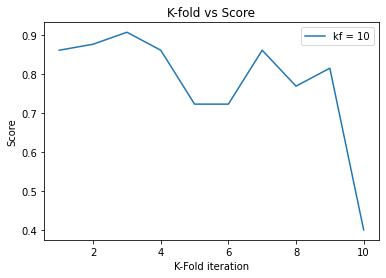

In [ ]:
# x = list(range(1, n_splits+1, 1))
x2 = list(range(1,11))
y2 = res_kf
plt.plot(x2, y2, label = "kf = 10")
plt.title("K-fold vs Score")
plt.xlabel('K-Fold iteration')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
cvres = grid.cv_results_
print(grid.best_score_)
# mean_scores_5 = []
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#   print(mean_score, params)
#   mean_scores_5.append(mean_score)

{'C': 1000, 'gamma': 100, 'kernel': 'rbf'}
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.8358974358974359


In [ ]:
# in requested C:1000 and gamma:1
mean_score_rbf = []
mean_score_linear = []
mean_score_poly = []
mean_score_sigmoid = []
req = 1
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  if params['gamma'] == req:
    print(mean_score, params)
    if params['kernel'] == 'rbf':
      mean_score_rbf.append(mean_score)
    elif params['kernel'] == 'linear':
      mean_score_linear.append(mean_score)
    elif params['kernel'] == 'poly':
      mean_score_poly.append(mean_score)
    else :
      mean_score_sigmoid.append(mean_score)

In [ ]:
print(mean_score_rbf)
print(mean_score_linear)
print(mean_score_poly)
print(mean_score_sigmoid)

In [ ]:
adjust_param = 'C'
#rbf
y1 = mean_score_rbf
x1 = param_grid[adjust_param ]
#linear
y2 = mean_score_linear
x2 = param_grid[adjust_param ]
#poly
y3 = mean_score_poly
x3 = param_grid[adjust_param ]
#sigmoid
y4 = mean_score_sigmoid
x4 = param_grid[adjust_param ]
plt.plot(x1, y1, label = "kernel = rbf")
plt.plot(x2, y2, label = "kernel = linear")
plt.plot(x3, y3, label = "kernel = poly")
plt.plot(x4, y4, label = "kernel = sigmoid")
plt.title("gamma: 1")
plt.xlabel(adjust_param)
plt.ylabel('Mean score')
plt.legend()
plt.show()

In [ ]:
%cd

In [ ]:
import joblib
# save the model to disk
filename = 'svm_kf10_83.6% acc.sav'
joblib.dump(grid, filename)

In [ ]:
# example of CDR
CDR = 0.6195
#load model svm
import joblib
model_name_classify = 'svm_kf10_83.6% acc.sav'
filepath = '/content/drive/MyDrive/HackathonIGI/' + model_name_classify
loaded_model = joblib.load(filepath)
Xtest = pd.DataFrame([CDR])
result = loaded_model.predict(Xtest)
print(result)